In [1]:
import random
import itertools
from pathlib import Path
from typing import ClassVar

import torch
import torchvision.utils as vutils
from torch import nn, optim
from torch.nn.utils.parametrizations import spectral_norm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision import io
from torchvision.datasets import SVHN
from tqdm.auto import tqdm
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
IMG_SIZE = 64
EPOCHS = 5
BATCH_SIZE = 256
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Model definition

In [3]:
class EncoderBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, kernel_size: int = 3, stride: int = 1, padding: int = 0
    ) -> None:
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class GeneratorBlock(nn.Module):
    leak: ClassVar[float] = 0.2

    def __init__(
        self, in_channels: int, out_channels: int, kernel_size: int = 3, stride: int = 1, padding: int = 0
    ) -> None:
        super().__init__()
        self.conv = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(negative_slope=self.leak, inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x


class SNDiscriminatorBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, kernel_size: int = 4, stride: int = 1, padding: int = 0
    ) -> None:
        super().__init__()
        self.conv = spectral_norm(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=True)
        )
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.activation(x)
        return x


class Encoder(nn.Module):
    n_blocks: ClassVar[int]

    def __init__(self, input_channels: int, latent_dim: int = 128, dim: int = 128) -> None:
        super().__init__()
        self.downs = nn.Sequential(
            *[
                EncoderBlock(dim if i else input_channels, dim, kernel_size=4, stride=2, padding=1)
                for i in range(self.n_blocks)
            ],
            EncoderBlock(dim, dim, kernel_size=4, stride=1, padding=0),
            nn.Conv2d(dim, latent_dim, kernel_size=1),
        )
        self.latent_dim = latent_dim

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.downs(x)


class Encoder32(Encoder):
    n_blocks = 3  # 32 = 4 * 2 ** n_blocks


class Encoder64(Encoder):
    n_blocks = 4  # 64 = 4 * 2 ** n_blocks


class Generator(nn.Module):
    n_blocks: ClassVar[int]

    def __init__(self, output_channels: int, latent_dim: int = 128, dim: int = 128) -> None:
        super().__init__()
        self.ups = nn.Sequential(
            GeneratorBlock(latent_dim, dim, kernel_size=4, stride=1, padding=0),
            *[GeneratorBlock(dim, dim, kernel_size=4, stride=2, padding=1) for _ in range(self.n_blocks - 1)],
            nn.ConvTranspose2d(dim, output_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        self.latent_dim = latent_dim

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.ups(x)


class Generator32(Generator):
    n_blocks = 3  # 32 = 4 * 2 ** n_blocks


class Generator64(Generator):
    n_blocks = 4  # 64 = 4 * 2 ** n_blocks


class Discriminator(nn.Module):
    n_blocks: ClassVar[int]

    def __init__(self, input_channels: int, latent_dim: int = 128, dim: int = 128) -> None:
        super().__init__()
        self.latent_dim = latent_dim
        self.x_mapping = nn.Sequential(
            *[
                SNDiscriminatorBlock(dim if i else input_channels, dim, kernel_size=4, stride=2, padding=1)
                for i in range(self.n_blocks)
            ],
            SNDiscriminatorBlock(dim, dim, kernel_size=4),
        )

        self.z_mapping = nn.Sequential(
            SNDiscriminatorBlock(latent_dim, dim, kernel_size=1), SNDiscriminatorBlock(dim, dim, kernel_size=1)
        )

        self.joint_mapping = nn.Sequential(
            SNDiscriminatorBlock(dim * 2, dim * 2, kernel_size=1),
            SNDiscriminatorBlock(dim * 2, dim * 2, kernel_size=1),
            spectral_norm(nn.Conv2d(dim * 2, 1, kernel_size=1)),
        )

    def forward(self, x: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        x = self.x_mapping(x)
        z = self.z_mapping(z)
        joint = torch.cat((x, z), dim=1)
        joint = self.joint_mapping(joint)
        return joint.view(-1, 1)


class Discriminator32(Discriminator):
    n_blocks = 3


class Discriminator64(Discriminator):
    n_blocks = 4


class BiSNGAN(nn.Module):
    def __init__(self, encoder: Encoder, generator: Generator, discriminator: Discriminator, amp: bool = False) -> None:
        super().__init__()
        self.encoder = encoder
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = self.encoder.latent_dim
        self.criterion = nn.BCEWithLogitsLoss()
        self.ge_optimizer = self.create_eg_optimizer()
        self.d_optimizer = self.create_d_optimizer()
        self.scaler = torch.cuda.amp.grad_scaler.GradScaler() if amp else None

    def create_eg_optimizer(self, lr: float = 1e-4, betas: tuple[float, float] = (0.5, 0.999)) -> optim.Optimizer:
        self.ge_optimizer = optim.Adam(
            itertools.chain(self.encoder.parameters(), self.generator.parameters()), lr=lr, betas=betas
        )
        return self.ge_optimizer

    def create_d_optimizer(self, lr: float = 1e-4, betas: tuple[float, float] = (0.5, 0.999)) -> optim.Optimizer:
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=lr, betas=betas)
        return self.d_optimizer

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(x)

    def generate(self, z: torch.Tensor) -> torch.Tensor:
        return self.generator(z)

    def reconstruct(self, x: torch.Tensor) -> torch.Tensor:
        return self.generate(self.encode(x))

    def discriminate(
        self, x: torch.Tensor, z_hat: torch.Tensor, x_tilde: torch.Tensor, z: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        x = torch.cat([x, x_tilde], dim=0)
        z = torch.cat([z_hat, z], dim=0)
        output = self.discriminator(x, z)
        data_preds, sample_preds = torch.tensor_split(output, 2, dim=0)
        return data_preds, sample_preds

    @torch.no_grad()
    def evaluate(self, eval_loader: DataLoader) -> torch.Tensor:
        rec_loss = []
        pbar = tqdm(total=len(eval_loader), leave=False)
        self.eval()
        for x in eval_loader:
            reconstructed = self.reconstruct(x)
            mse = nn.functional.mse_loss(input=reconstructed, target=x)
            pbar.set_description(f"reconstruction loss: {mse.item():.3f}")
            rec_loss.append(mse)
            pbar.update()
        pbar.close()
        return torch.mean(torch.tensor(rec_loss))

    def train_single_epoch(self, train_loader: DataLoader) -> tuple[float, float]:
        ge_loss = 0.0
        d_loss = 0.0
        pbar = tqdm(total=len(train_loader), leave=False)
        self.train()
        for x in train_loader:
            with torch.cuda.amp.autocast(enabled=self.scaler is not None, dtype=torch.float16):
                _ge_loss, _d_loss = self.train_step(x)
            pbar.set_description(
                f"Generator/Encoder loss: {_ge_loss.item():.3f}. Discriminator loss: {_d_loss.item():.3f}"
            )
            ge_loss += _ge_loss.item()
            d_loss += _d_loss.item()
            pbar.update()
        pbar.close()

        return ge_loss / len(train_loader), d_loss / len(train_loader)

    def train_step(self, x_real: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        y_real = torch.ones((x_real.size(0), 1), device=x_real.device)
        y_fake = torch.zeros_like(y_real)

        z_fake = torch.randn(x_real.size(0), self.latent_dim, 1, 1, device=x_real.device)
        z_real = self.encode(x_real)  # keep the graph untouched while training discriminator

        x_fake = self.generate(z_fake)  # keep the graph untouched while training discriminator

        # 1. train the discriminator
        self.d_optimizer.zero_grad()

        real_preds, fake_preds = self.discriminate(x_real, z_fake, x_fake.detach(), z_real.detach())
        d_loss: torch.Tensor = self.criterion(real_preds, y_real) + self.criterion(fake_preds, y_fake)

        if self.scaler is not None:  # for amp
            self.scaler.scale(d_loss).backward()
            self.scaler.step(self.d_optimizer)
        else:
            d_loss.backward()
            self.d_optimizer.step()

        # 2. train the encoder and generator
        self.ge_optimizer.zero_grad()

        real_preds, fake_preds = self.discriminate(x_real, z_fake, x_fake, z_real)
        ge_loss: torch.Tensor = self.criterion(fake_preds, y_real) + self.criterion(real_preds, y_fake)

        if self.scaler is not None:  # for amp
            self.scaler.scale(ge_loss).backward()
            self.scaler.step(self.ge_optimizer)
        else:
            ge_loss.backward()
            self.ge_optimizer.step()

        if self.scaler is not None:
            self.scaler.update()

        return d_loss, ge_loss


In [4]:
dirs = set(Path("/kaggle/input/ucbo-tiles-256-1/").iterdir())

In [5]:
random.seed(42)
train_dirs = set(random.sample(list(dirs), k=int(len(dirs) * 0.8)))
eval_dirs = set(dirs).difference(train_dirs)

In [6]:
train_images = list(itertools.chain.from_iterable([d.glob("*.png") for d in train_dirs]))
eval_images = list(itertools.chain.from_iterable(d.glob("*.png") for d in eval_dirs))

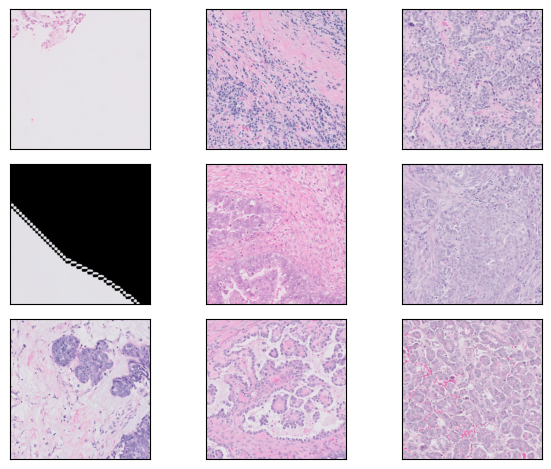

In [7]:
fig, axes = plt.subplots(3, 3)

sample_images = random.choices(list(train_images), k=9)

for i in range(9):
    axes.flatten()[i].imshow(Image.open(sample_images[i]))
    axes.flatten()[i].set_xticks([])
    axes.flatten()[i].set_yticks([])
    
fig.tight_layout()
fig.show()

In [8]:
class PoCDataset(Dataset):
    def __init__(self, images: list[Path], transforms: transforms.Compose) -> None:
        self.images = images
        self.transforms = transforms
    
    def __len__(self) -> int:
        return len(self.images)
    
    def __getitem__(self, idx: int) -> None:
        img = io.read_image(str(self.images[idx])) / 255.
        return self.transforms(img)

In [9]:
train_transforms = transforms.Compose(
    [
        transforms.Lambda(lambd=lambda i: i.to(DEVICE)),
        transforms.RandomCrop(size=IMG_SIZE),
        transforms.Normalize(mean=[0.5,]*3, std=[0.5,]*3)
    ]
)

eval_transforms = transforms.Compose(
    [
        transforms.Lambda(lambd=lambda i: i.to(DEVICE)),
        transforms.CenterCrop(size=IMG_SIZE),
        transforms.Normalize(mean=[0.5,]*3, std=[0.5,]*3)
    ]
)

reverse_transform = transforms.Compose(
    [
        transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2]),
        transforms.ToPILImage()
    ]
)

In [10]:
train_ds = PoCDataset(images=train_images, transforms=train_transforms)
eval_ds = PoCDataset(images=eval_images, transforms=eval_transforms)

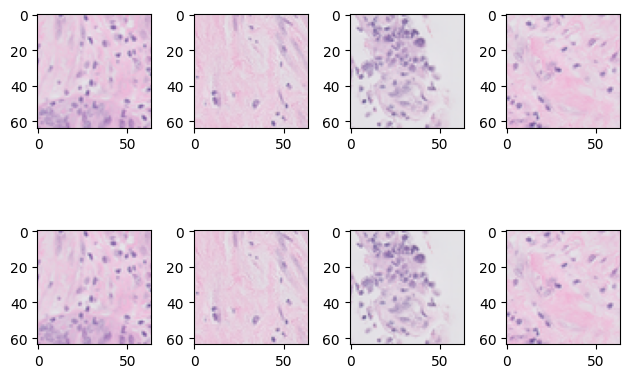

In [11]:
fig, axes = plt.subplots(2, 4)

for i in range(4):
    axes[0, i].imshow(
        Image.open(
            eval_ds.images[i]).crop(
                (
                    (256 - IMG_SIZE) // 2, (256 - IMG_SIZE) / 2, 
                    (256 + IMG_SIZE) / 2, (256 + IMG_SIZE) / 2
                )
        )
    )
    axes[1, i].imshow(reverse_transform(eval_ds[i]))

fig.tight_layout()
fig.show()

In [12]:
dataloader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(dataset=eval_ds, batch_size=BATCH_SIZE*2, shuffle=False)

In [13]:
generator = Generator64(output_channels=3)
encoder = Encoder64(input_channels=3)
discriminator = Discriminator64(input_channels=3)
model = BiSNGAN(encoder=encoder, generator=generator, discriminator=discriminator, amp=torch.cuda.is_available())
model = model.to(DEVICE)

In [14]:
pbar = tqdm(total=EPOCHS)

for epoch in range(EPOCHS):
    ge_loss, disc_loss = model.train_single_epoch(train_loader=dataloader)

    rec_loss = model.evaluate(eval_loader=eval_loader)
    pbar.set_description(f"epoch: {epoch} Reconstruction loss: {rec_loss:.3f}")
    
    with torch.no_grad():
        gen = model.generate(torch.randn(64, 128, 1, 1, device=DEVICE))
        rec = model.reconstruct(next(iter(eval_loader))[:64])

    gen_img = reverse_transform(vutils.make_grid(gen, nrow=8))
    gen_img.save(f"epoch_{epoch}_generated.png")

    rec_img = reverse_transform(vutils.make_grid(rec, nrow=8))
    rec_img.save(f"epoch_{epoch}_reconstructed.png")

    torch.save(model.state_dict(), f"bigan_epoch{epoch}_rec_loss{rec_loss:.3f}.pth")

    pbar.update()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

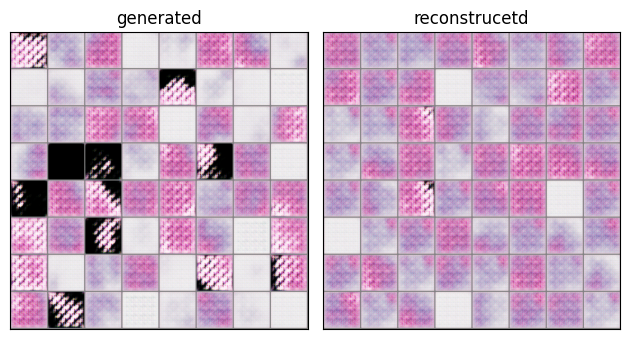

In [15]:
fig, axes = plt.subplots(1, 2)

axes[0].imshow(gen_img)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("generated")
axes[1].imshow(rec_img)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("reconstrucetd")

fig.tight_layout()
fig.show()